In [ ]:
""" https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf
https://www.youtube.com/watch?v=NP8pXZdU-5U&t=1s """
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from SnakeEnvironment import *
import collections
import random
from itertools import count
from Util import *

TRY:
- Longer training
- More layers in NN
- Bigger layers in NN
- Different loss

In [57]:
GAMMA = 0.99
EPS_MAX = 1.0
EPS_START = 0.5
EPS_END = 0.01
EPS_DECAY = 0.000001
MY_SEED = 1
LR = 0.0001

state_size = 12
nr_actions = 4


In [58]:
def choose_action(observation: torch.Tensor, q_table, eps):
    assert type(observation) is torch.Tensor, f'Observation should be torch tensor but is: {type(observation)}.'
    if torch.rand(1).item() > eps:
        # Exploitation (relying on Q value)
        #print(" q table:")
        actions = torch.tensor(q_table[state_2_int(observation)])
        #print("actions:",actions)
        best_action = torch.argmax(actions).item()
        #print("best_action:",best_action)
        return best_action
    else:
        #print("random:")
        # Exploration (random action)
        random_action = torch.randint(low=0, high=nr_actions, size=(1,)).item()
        #print("random_action:",random_action)
        return random_action


In [59]:
torch.manual_seed(MY_SEED)
np.random.seed(MY_SEED)

# Creating Q table
q_table = initialize_Q_table(state_space_size=state_size)

NUM_EPISODES = 50000

episode_durations = []
episode_rewards = []
episode_exploration_rates = []

for i_episode in tqdm(range(NUM_EPISODES)):
    # Initialize the environment and state
    game_env = SnakeEnvironment(seed=MY_SEED + i_episode,  # Try both constant seed and varying seed for each episode
                                display_gameplay=False)
    game_env.initialize_environment()

    current_game_score = 0
    current_game_duration = 0

    current_exploration_rate = 0
    current_steps_counter = 0
    game_over = False
    current_state = game_env.get_state()

    for t in count():
        # Select and perform an action according to greedy epsilon strategy
        action = choose_action(observation=current_state, q_table=q_table, eps=EPS_START)

        # Perform action in game environment and observe reward and new state + termination flag.
        reward, game_over, new_observation = game_env.step(action)
        current_game_score += reward
        reward = torch.tensor([reward])

        # Updating q table based on new experience
        q_table[state_2_int(current_state)][action]  *= (1.0 - LR)
        q_table[state_2_int(current_state)][action]  += LR * (reward + GAMMA * np.max(q_table[state_2_int(new_observation)]))

        # Updating epsilon
        EPS_START = EPS_END + (EPS_START - EPS_END) * np.exp(
        -EPS_DECAY * i_episode)

        if game_over:
            break
        current_game_duration += 1

    episode_rewards.append(current_game_score)
    episode_durations.append(current_game_duration)
    episode_exploration_rates.append(EPS_START)


 11%|█▏        | 5685/50000 [00:08<01:07, 652.17it/s]


KeyboardInterrupt: 

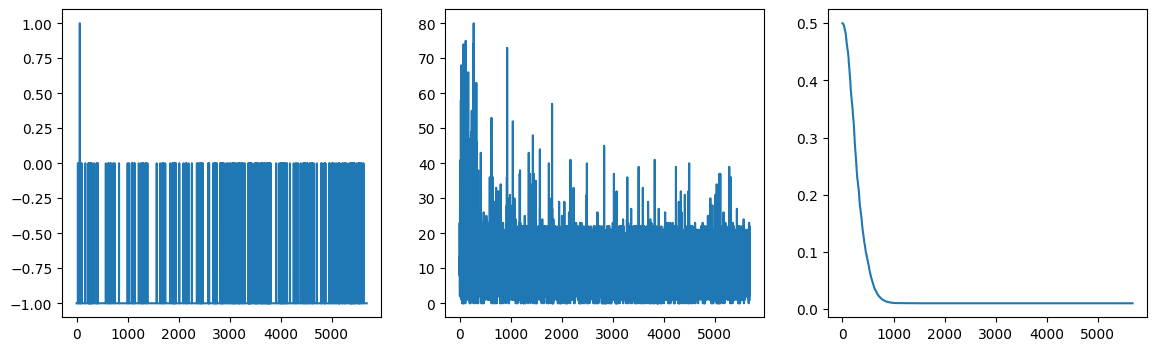

In [60]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot([i for i in range(len(episode_rewards))], episode_rewards)
ax[1].plot([i for i in range(len(episode_durations))], episode_durations)
ax[2].plot([i for i in range(len(episode_exploration_rates))], episode_exploration_rates)
plt.show()

In [55]:
avg_period = NUM_EPISODES//100
avg_episode_rewards, avg_episode_durations, avg_episode_exploration_rates = [], [], []
for period in range(0, len(episode_rewards) // avg_period):
    avg_episode_rewards.append(np.mean(episode_rewards[avg_period * period : avg_period * (period + 1)]))
    avg_episode_durations.append(np.mean(episode_durations[avg_period * period : avg_period * (period + 1)]))
    avg_episode_exploration_rates.append(np.mean(episode_exploration_rates[avg_period * period : avg_period * (period + 1)]))

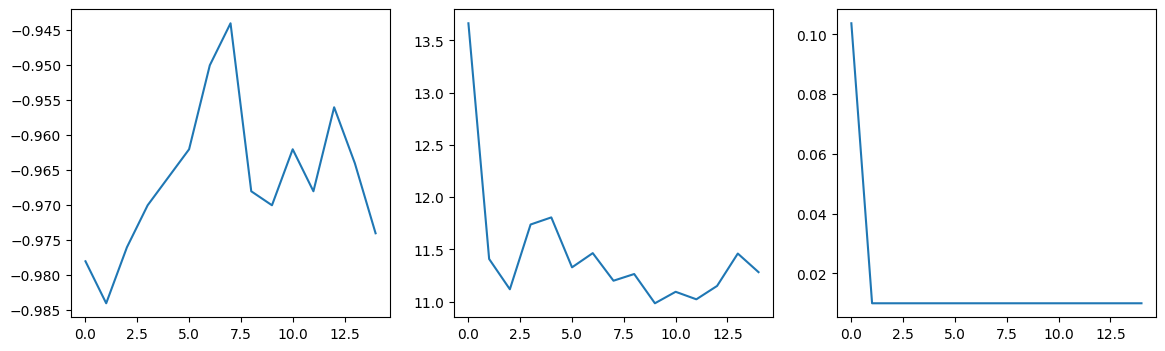

In [56]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot([ i for i in range(len(avg_episode_rewards))], avg_episode_rewards)
ax[1].plot([ i for i in range(len(avg_episode_durations))], avg_episode_durations)
ax[2].plot([ i for i in range(len(avg_episode_exploration_rates))], avg_episode_exploration_rates)
plt.show()

In [ ]:
Play_game = True
if Play_game:
    game_env = SnakeEnvironment(seed=1,  # Try both constant seed and varying seed for each episode
                                neural_net=agent_007.policy_network,
                                display_gameplay=True,
                                graphics_speed=4)
    game_env.run()

